In [2]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, f1_score
from imblearn.combine import SMOTETomek
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import tensorflow as tf
import keras.backend as K

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Load your dataset
df = pd.read_csv('Dev_data_to_be_shared.csv')

# Define target and features
if 'account_number' in df.columns:
    df = df.drop('account_number', axis=1)

df = df.dropna(axis=1, how='all')

# Drop columns that have more than 80% missing values
threshold = 0.2 * len(df)
df = df.dropna(axis=1, thresh=threshold)

target = 'bad_flag'
features = df.drop(target, axis=1).columns.tolist()

X = df[features]
y = df[target]

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Handle class imbalance
def balanced_preprocessing(X, y):
    smote_tomek = SMOTETomek(sampling_strategy=0.5, random_state=42, n_jobs=-1)
    X_balanced, y_balanced = smote_tomek.fit_resample(X, y)
    return X_balanced, y_balanced

X_balanced, y_balanced = balanced_preprocessing(X, y)

# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define custom F1 score metric
def f1_m(y_true, y_pred):
    precision = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_pred, 0, 1))) + K.epsilon())
    recall = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_true, 0, 1))) + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

# Define the neural network model
def create_model(input_dim):
    model = Sequential()

    # Add Conv1D layers
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(input_dim, 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    # Fully connected layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy', f1_m])
    return model

input_dim = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Run the model within a GPU context
with tf.device('/GPU:0'):
    model = create_model(input_dim)

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1, validation_split=0.2)

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Neural Network Model accuracy: {accuracy:.2f}")
print(f"Neural Network F1-score: {f1:.2f}")
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred))

# Save the trained model and scaler
model.save('neural_network_model.h5')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(imputer, 'imputer.pkl')
print(f"Neural Network Model, Scaler, and Imputer saved.")

# Example: Load the saved model and scaler to make predictions
from tensorflow.keras.models import load_model

loaded_model = load_model('neural_network_model.h5', custom_objects={'f1_m': f1_m})
loaded_scaler = joblib.load('scaler.pkl')
loaded_imputer = joblib.load('imputer.pkl')

# Example new data (replace with actual new data)
# Ensure new data has the same number of features
new_data = np.zeros((1, input_dim))  # Replace with actual new data of shape (1, input_dim)
new_data[:, :4] = np.array([[5.1, 3.5, 1.4, 0.2]])  # Replace only the relevant features

new_data_imputed = loaded_imputer.transform(new_data)
scaled_data = loaded_scaler.transform(new_data_imputed)
scaled_data = scaled_data.reshape(scaled_data.shape[0], scaled_data.shape[1], 1)

# Neural Network prediction
nn_prediction = (loaded_model.predict(scaled_data) > 0.5).astype("int32")
print(f"Neural Network Prediction: {nn_prediction}")

Num GPUs Available:  1


c:\Users\allmi\anaconda3\envs\ai-gpu\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Epoch 1/100
2862/2862 [==============================] - 36s 8ms/step - loss: 0.3828 - accuracy: 0.8317 - f1_m: 0.7052 - val_loss: 0.4798 - val_accuracy: 0.7668 - val_f1_m: 0.7310
Epoch 2/100
2862/2862 [==============================] - 22s 8ms/step - loss: 0.2669 - accuracy: 0.8839 - f1_m: 0.8008 - val_loss: 0.4804 - val_accuracy: 0.7955 - val_f1_m: 0.7558
Epoch 3/100
2862/2862 [==============================] - 24s 8ms/step - loss: 0.2364 - accuracy: 0.8984 - f1_m: 0.8270 - val_loss: 0.2476 - val_accuracy: 0.9136 - val_f1_m: 0.8737
Epoch 4/100
2862/2862 [==============================] - 24s 8ms/step - loss: 0.2196 - accuracy: 0.9036 - f1_m: 0.8355 - val_loss: 0.2697 - val_accuracy: 0.8883 - val_f1_m: 0.8474
Epoch 5/100
2862/2862 [==============================] - 24s 8ms/step - loss: 0.2064 - accuracy: 0.9098 - f1_m: 0.8487 - val_loss: 0.2633 - val_accuracy: 0.8954 - val_f1_m: 0.8557
Epoch 6/100
2862/2862 [==============================] - 24s 8ms/step - loss: 0.1965 - accuracy: 0.9

c:\Users\allmi\anaconda3\envs\ai-gpu\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, f1_score
from imblearn.combine import SMOTETomek
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import tensorflow as tf
import keras.backend as K

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Load your dataset
df = pd.read_csv('Dev_data_to_be_shared.csv')

# Define target and features
if 'account_number' in df.columns:
    df = df.drop('account_number', axis=1)

# Store the original feature names
original_features = df.columns.tolist()
original_features.remove('bad_flag')

# Drop columns that are completely empty
df = df.dropna(axis=1, how='all')

# Drop columns that have more than 80% missing values
threshold = 0.2 * len(df)
df = df.dropna(axis=1, thresh=threshold)

# Store the final feature names
final_features = df.drop('bad_flag', axis=1).columns.tolist()

# Identify dropped features
dropped_features = list(set(original_features) - set(final_features))

# Print dropped and used features
print(f"Dropped Features ({len(dropped_features)}): {dropped_features}")
print(f"Used Features ({len(final_features)}): {final_features}")

# Continue with the rest of the preprocessing and model training
target = 'bad_flag'
features = df.drop(target, axis=1).columns.tolist()

X = df[features]
y = df[target]

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Handle class imbalance
def balanced_preprocessing(X, y):
    smote_tomek = SMOTETomek(sampling_strategy=0.5, random_state=42, n_jobs=-1)
    X_balanced, y_balanced = smote_tomek.fit_resample(X, y)
    return X_balanced, y_balanced

X_balanced, y_balanced = balanced_preprocessing(X, y)

# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define custom F1 score metric
def f1_m(y_true, y_pred):
    precision = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_pred, 0, 1))) + K.epsilon())
    recall = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_true, 0, 1))) + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

# Define the neural network model
def create_model(input_dim):
    model = Sequential()

    # Add Conv1D layers
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(input_dim, 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    # Fully connected layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy', f1_m])
    return model

input_dim = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Run the model within a GPU context
with tf.device('/GPU:0'):
    model = create_model(input_dim)

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1, validation_split=0.2)

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Neural Network Model accuracy: {accuracy:.2f}")
print(f"Neural Network F1-score: {f1:.2f}")
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred))

# Save the trained model and scaler
model.save('neural_network_model.h5')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(imputer, 'imputer.pkl')
print(f"Neural Network Model, Scaler, and Imputer saved.")

# Example: Load the saved model and scaler to make predictions
from tensorflow.keras.models import load_model

loaded_model = load_model('neural_network_model.h5', custom_objects={'f1_m': f1_m})
loaded_scaler = joblib.load('scaler.pkl')
loaded_imputer = joblib.load('imputer.pkl')

# Example new data (replace with actual new data)
# Ensure new data has the same number of features
new_data = np.zeros((1, input_dim))  # Replace with actual new data of shape (1, input_dim)
new_data[:, :4] = np.array([[5.1, 3.5, 1.4, 0.2]])  # Replace only the relevant features

new_data_imputed = loaded_imputer.transform(new_data)
scaled_data = loaded_scaler.transform(new_data_imputed)
scaled_data = scaled_data.reshape(scaled_data.shape[0], scaled_data.shape[1], 1)

# Neural Network prediction
nn_prediction = (loaded_model.predict(scaled_data) > 0.5).astype("int32")
print(f"Neural Network Prediction: {nn_prediction}")

Num GPUs Available:  1
Dropped Features (14): ['bureau_438', 'bureau_444', 'onus_attribute_47', 'bureau_449', 'bureau_436', 'onus_attribute_45', 'onus_attribute_44', 'bureau_448', 'bureau_148', 'bureau_447', 'onus_attribute_46', 'onus_attribute_48', 'bureau_446', 'onus_attribute_43']
Used Features (1200): ['onus_attribute_1', 'transaction_attribute_1', 'transaction_attribute_2', 'transaction_attribute_3', 'transaction_attribute_4', 'transaction_attribute_5', 'transaction_attribute_6', 'transaction_attribute_7', 'transaction_attribute_8', 'transaction_attribute_9', 'transaction_attribute_10', 'transaction_attribute_11', 'transaction_attribute_12', 'transaction_attribute_13', 'transaction_attribute_14', 'transaction_attribute_15', 'transaction_attribute_16', 'transaction_attribute_17', 'transaction_attribute_18', 'transaction_attribute_19', 'transaction_attribute_20', 'transaction_attribute_21', 'transaction_attribute_22', 'transaction_attribute_23', 'transaction_attribute_24', 'transact

c:\Users\allmi\anaconda3\envs\ai-gpu\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Epoch 1/100
2862/2862 [==============================] - 25s 8ms/step - loss: 0.4201 - accuracy: 0.8191 - f1_m: 0.7254 - val_loss: 0.9185 - val_accuracy: 0.6056 - val_f1_m: 0.6213
Epoch 2/100
2862/2862 [==============================] - 23s 8ms/step - loss: 0.2993 - accuracy: 0.8791 - f1_m: 0.8061 - val_loss: 0.5878 - val_accuracy: 0.7514 - val_f1_m: 0.7197
Epoch 3/100
2862/2862 [==============================] - 24s 8ms/step - loss: 0.2705 - accuracy: 0.8910 - f1_m: 0.8210 - val_loss: 0.3695 - val_accuracy: 0.8542 - val_f1_m: 0.8092
Epoch 4/100
2862/2862 [==============================] - 24s 8ms/step - loss: 0.2504 - accuracy: 0.9010 - f1_m: 0.8383 - val_loss: 0.3652 - val_accuracy: 0.8628 - val_f1_m: 0.8199
Epoch 5/100
2862/2862 [==============================] - 24s 8ms/step - loss: 0.2362 - accuracy: 0.9080 - f1_m: 0.8493 - val_loss: 0.3251 - val_accuracy: 0.8722 - val_f1_m: 0.8286
Epoch 6/100
2862/2862 [==============================] - 28s 10ms/step - loss: 0.2299 - accuracy: 0.

c:\Users\allmi\anaconda3\envs\ai-gpu\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [10]:
l1 = ['bureau_148', 'bureau_436', 'bureau_438', 'bureau_444', 'bureau_446', 'bureau_447', 'bureau_448', 'bureau_449', 'onus_attribute_43', 'onus_attribute_44', 'onus_attribute_45', 'onus_attribute_46', 'onus_attribute_47', 'onus_attribute_48']
dataf.drop(l1, axis=1, inplace=True)

In [13]:
dataf.to_csv('new_excel_file.csv', index=False)

Num GPUs Available:  1
Dropped Features (14): ['bureau_438', 'onus_attribute_47', 'bureau_448', 'onus_attribute_44', 'bureau_449', 'onus_attribute_43', 'bureau_148', 'onus_attribute_45', 'bureau_444', 'bureau_446', 'onus_attribute_48', 'bureau_436', 'bureau_447', 'onus_attribute_46']
Used Features (1200): ['onus_attribute_1', 'transaction_attribute_1', 'transaction_attribute_2', 'transaction_attribute_3', 'transaction_attribute_4', 'transaction_attribute_5', 'transaction_attribute_6', 'transaction_attribute_7', 'transaction_attribute_8', 'transaction_attribute_9', 'transaction_attribute_10', 'transaction_attribute_11', 'transaction_attribute_12', 'transaction_attribute_13', 'transaction_attribute_14', 'transaction_attribute_15', 'transaction_attribute_16', 'transaction_attribute_17', 'transaction_attribute_18', 'transaction_attribute_19', 'transaction_attribute_20', 'transaction_attribute_21', 'transaction_attribute_22', 'transaction_attribute_23', 'transaction_attribute_24', 'transact

c:\Users\allmi\anaconda3\envs\ai-gpu\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Epoch 1/100
2862/2862 [==============================] - 28s 7ms/step - loss: 0.0000e+00 - accuracy: 0.3339 - f1_m: 0.4946 - val_loss: 0.0000e+00 - val_accuracy: 0.3342 - val_f1_m: 0.4954
Epoch 2/100
2862/2862 [==============================] - 20s 7ms/step - loss: 0.0000e+00 - accuracy: 0.3339 - f1_m: 0.4946 - val_loss: 0.0000e+00 - val_accuracy: 0.3342 - val_f1_m: 0.4954
Epoch 3/100
2862/2862 [==============================] - 22s 8ms/step - loss: 0.0000e+00 - accuracy: 0.3339 - f1_m: 0.4947 - val_loss: 0.0000e+00 - val_accuracy: 0.3342 - val_f1_m: 0.4954
Epoch 4/100
2862/2862 [==============================] - 22s 8ms/step - loss: 0.0000e+00 - accuracy: 0.3339 - f1_m: 0.4947 - val_loss: 0.0000e+00 - val_accuracy: 0.3342 - val_f1_m: 0.4954
Epoch 5/100
2862/2862 [==============================] - 21s 7ms/step - loss: 0.0000e+00 - accuracy: 0.3339 - f1_m: 0.4948 - val_loss: 0.0000e+00 - val_accuracy: 0.3342 - val_f1_m: 0.4954
Epoch 6/100
2862/2862 [==============================] - 23s

c:\Users\allmi\anaconda3\envs\ai-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\allmi\anaconda3\envs\ai-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\allmi\anaconda3\envs\ai-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Neural Network Model, Scaler, and Imputer saved.


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, f1_score
from imblearn.combine import SMOTETomek
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import tensorflow as tf
import keras.backend as K

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Load your dataset
df = pd.read_csv('Dev_data_to_be_shared.csv')

# Define target and features
if 'account_number' in df.columns:
    df = df.drop('account_number', axis=1)

# Store the original feature names
original_features = df.columns.tolist()
original_features.remove('bad_flag')

# Drop columns that are completely empty
df = df.dropna(axis=1, how='all')

# Drop columns that have more than 80% missing values
threshold = 0.2 * len(df)
df = df.dropna(axis=1, thresh=threshold)

# Store the final feature names
final_features = df.drop('bad_flag', axis=1).columns.tolist()

# Identify dropped features
dropped_features = list(set(original_features) - set(final_features))

# Print dropped and used features
print(f"Dropped Features ({len(dropped_features)}): {dropped_features}")
print(f"Used Features ({len(final_features)}): {final_features}")

# Continue with the rest of the preprocessing and model training
target = 'bad_flag'
features = df.drop(target, axis=1).columns.tolist()

X = df[features]
y = df[target]

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Handle class imbalance
def balanced_preprocessing(X, y):
    smote_tomek = SMOTETomek(sampling_strategy=0.5, random_state=42, n_jobs=-1)
    X_balanced, y_balanced = smote_tomek.fit_resample(X, y)
    return X_balanced, y_balanced

X_balanced, y_balanced = balanced_preprocessing(X, y)

# Split the balanced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define custom F1 score metric
def f1_m(y_true, y_pred):
    precision = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_pred, 0, 1))) + K.epsilon())
    recall = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_true, 0, 1))) + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

# Define the neural network model
def create_model(input_dim):
    model = Sequential()

    # Add Conv1D layers
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(input_dim, 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    # Fully connected layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy', f1_m])
    return model

input_dim = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Run the model within a GPU context
with tf.device('/GPU:0'):
    model = create_model(input_dim)

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1, validation_split=0.2)

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Neural Network Model accuracy: {accuracy:.2f}")
print(f"Neural Network F1-score: {f1:.2f}")
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred))

# Save the trained model and scaler
model.save('neural_network_model.h5')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(imputer, 'imputer.pkl')
print(f"Neural Network Model, Scaler, and Imputer saved.")

# # Example: Load the saved model and scaler to make predictions
# from tensorflow.keras.models import load_model

# loaded_model = load_model('neural_network_model.h5', custom_objects={'f1_m': f1_m})
# loaded_scaler = joblib.load('scaler.pkl')
# loaded_imputer = joblib.load('imputer.pkl')

# # Example new data (replace with actual new data)
# new_data = np.zeros((1, input_dim))  # Replace with actual new data of shape (1, input_dim)
# new_data[:, :4] = np.array([[5.1, 3.5, 1.4, 0.2]])  # Replace only the relevant features

# # Ensure new data has the same preprocessing
# new_data_df = pd.DataFrame(new_data, columns=final_features)  # Convert new data to DataFrame with the same columns as training data

# # Add any missing columns with 0 values to match the training data
# for col in final_features:
#     if col not in new_data_df.columns:
#         new_data_df[col] = 0

# # Ensure the columns are in the same order as the training data
# new_data_df = new_data_df[final_features]

# # Transform the new data using the same imputer and scaler
# new_data_imputed = loaded_imputer.transform(new_data_df)
# scaled_data = loaded_scaler.transform(new_data_imputed)
# scaled_data = scaled_data.reshape(scaled_data.shape[0], scaled_data.shape[1], 1)

# # Make prediction
# nn_prediction = (loaded_model.predict(scaled_data) > 0.5).astype("int32")
# print(f"Neural Network Prediction: {nn_prediction}")

Num GPUs Available:  1
Dropped Features (14): ['bureau_438', 'onus_attribute_47', 'bureau_448', 'onus_attribute_44', 'bureau_449', 'onus_attribute_43', 'bureau_148', 'onus_attribute_45', 'bureau_444', 'bureau_446', 'onus_attribute_48', 'bureau_436', 'bureau_447', 'onus_attribute_46']
Used Features (1200): ['onus_attribute_1', 'transaction_attribute_1', 'transaction_attribute_2', 'transaction_attribute_3', 'transaction_attribute_4', 'transaction_attribute_5', 'transaction_attribute_6', 'transaction_attribute_7', 'transaction_attribute_8', 'transaction_attribute_9', 'transaction_attribute_10', 'transaction_attribute_11', 'transaction_attribute_12', 'transaction_attribute_13', 'transaction_attribute_14', 'transaction_attribute_15', 'transaction_attribute_16', 'transaction_attribute_17', 'transaction_attribute_18', 'transaction_attribute_19', 'transaction_attribute_20', 'transaction_attribute_21', 'transaction_attribute_22', 'transaction_attribute_23', 'transaction_attribute_24', 'transact

c:\Users\allmi\anaconda3\envs\ai-gpu\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Epoch 1/100
2862/2862 [==============================] - 24s 8ms/step - loss: 0.3885 - accuracy: 0.8319 - f1_m: 0.7273 - val_loss: 0.7729 - val_accuracy: 0.6318 - val_f1_m: 0.6367
Epoch 2/100
2862/2862 [==============================] - 23s 8ms/step - loss: 0.2796 - accuracy: 0.8856 - f1_m: 0.8161 - val_loss: 0.3943 - val_accuracy: 0.8376 - val_f1_m: 0.7926
Epoch 3/100
2862/2862 [==============================] - 23s 8ms/step - loss: 0.2490 - accuracy: 0.9004 - f1_m: 0.8396 - val_loss: 0.3835 - val_accuracy: 0.8426 - val_f1_m: 0.7994
Epoch 4/100
2862/2862 [==============================] - 23s 8ms/step - loss: 0.2348 - accuracy: 0.9063 - f1_m: 0.8492 - val_loss: 0.4248 - val_accuracy: 0.8372 - val_f1_m: 0.7949
Epoch 5/100
2862/2862 [==============================] - 23s 8ms/step - loss: 0.2187 - accuracy: 0.9129 - f1_m: 0.8587 - val_loss: 0.4085 - val_accuracy: 0.8275 - val_f1_m: 0.7855
Epoch 6/100
2862/2862 [==============================] - 23s 8ms/step - loss: 0.2101 - accuracy: 0.9

In [1]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model

# Define custom F1 score metric again for loading the model
import keras.backend as K

def f1_m(y_true, y_pred):
    precision = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_pred, 0, 1))) + K.epsilon())
    recall = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_true, 0, 1))) + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

# Load the saved model, scaler, and imputer
model = load_model('neural_network_model.h5', custom_objects={'f1_m': f1_m})
scaler = joblib.load('scaler.pkl')
imputer = joblib.load('imputer.pkl')

# Load the original dataset to get feature names and preprocessing steps
df = pd.read_csv('Dev_data_to_be_shared.csv')

# Define target and features
if 'account_number' in df.columns:
    df = df.drop('account_number', axis=1)

# Preprocessing steps to match training data
df = df.dropna(axis=1, how='all')
threshold = 0.2 * len(df)
df = df.dropna(axis=1, thresh=threshold)

target = 'bad_flag'
features = df.drop(target, axis=1).columns.tolist()

# Load the validation dataset
validation_df = pd.read_csv('validation_data_to_be_shared.csv')

# Extract account numbers for the result CSV
account_numbers = validation_df['account_number']

# Drop the account number column for processing
validation_df = validation_df.drop('account_number', axis=1)

# Ensure validation data has the same features as the training data
validation_df = validation_df.reindex(columns=features, fill_value=0)

# Transform the validation data using the same imputer and scaler
validation_data_imputed = imputer.transform(validation_df)
validation_data_scaled = scaler.transform(validation_data_imputed)
validation_data_scaled = validation_data_scaled.reshape(validation_data_scaled.shape[0], validation_data_scaled.shape[1], 1)  # Reshape for Conv1D layer

# Make prediction and get probabilities
probabilities = model.predict(validation_data_scaled)
predictions = (probabilities > 0.4).astype("int32")

# Create a DataFrame with account numbers, predicted 'bad_flag', and probabilities
result_df = pd.DataFrame({
    'account_number': account_numbers,
    'bad_flag': predictions.flatten(),
    'probability': probabilities.flatten()
})

# Save the result to a new CSV file
result_df.to_csv('Validation_results.csv', index=False)

print(f"Predictions saved to Validation_results.csv")

1306/1306 [==============================] - 7s 2ms/step
Predictions saved to Validation_results.csv


In [2]:
import pandas as pd

import csv

def count_ones_in_column(file_path, column_name):
    count = 0
    with open(file_path, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            if column_name in row:
                count += row[column_name].count('1')
    return count

# Example usage:
file_path = 'Validation_results.csv'
column_name = 'bad_flag'  # Replace with the specific column name
ones_count = count_ones_in_column(file_path, column_name)
print(f'The number of ones in the column "{column_name}" is: {ones_count}')

The number of ones in the column "bad_flag" is: 448


C:\Users\allmi\AppData\Local\Temp\ipykernel_20612\2458571251.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cluster'] = kmeans.fit_predict(normalized_data)


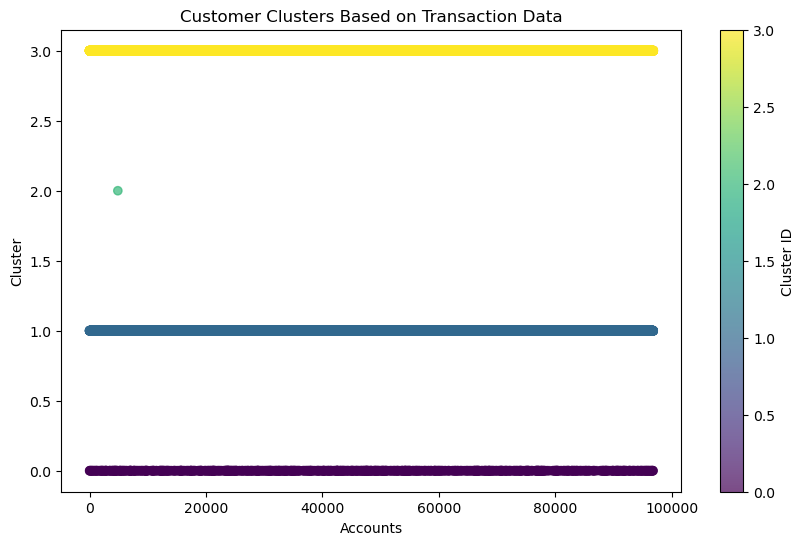


Insight 1: Spending Elasticity


C:\Users\allmi\AppData\Local\Temp\ipykernel_20612\2458571251.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['spending_elasticity'] = df[transaction_cols].sum(axis=1) / (df[onus_cols].sum(axis=1) + 1e-9)


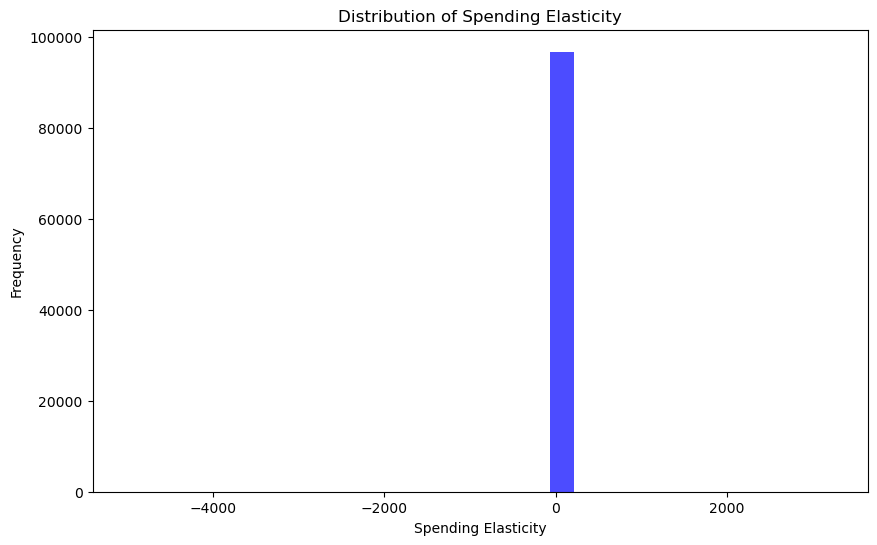


Insight 2: Financial Stress Prediction


C:\Users\allmi\AppData\Local\Temp\ipykernel_20612\2458571251.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['financial_stress_score'] = (


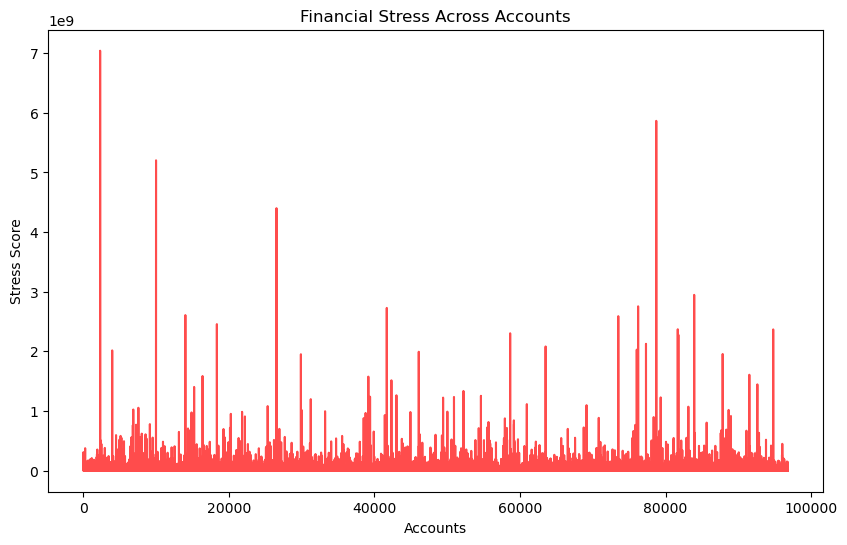


Insight 3: Overleveraged Customers


C:\Users\allmi\AppData\Local\Temp\ipykernel_20612\2458571251.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['overleveraged'] = df[bureau_cols].sum(axis=1) > df[transaction_cols].sum(axis=1)


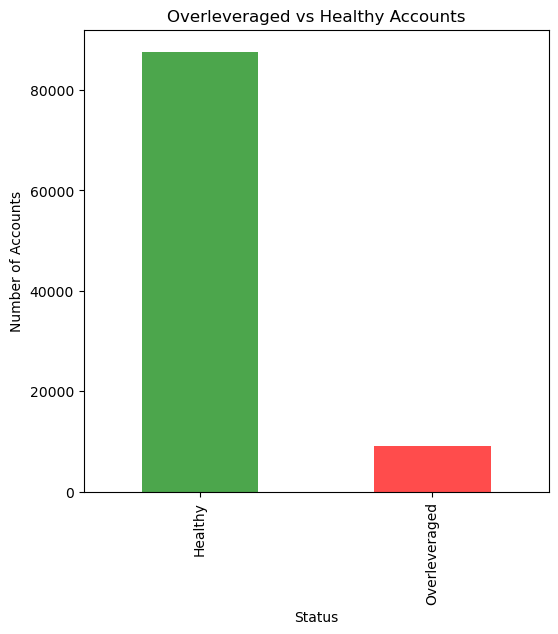


Insight 5: High-Spending Merchant Categories


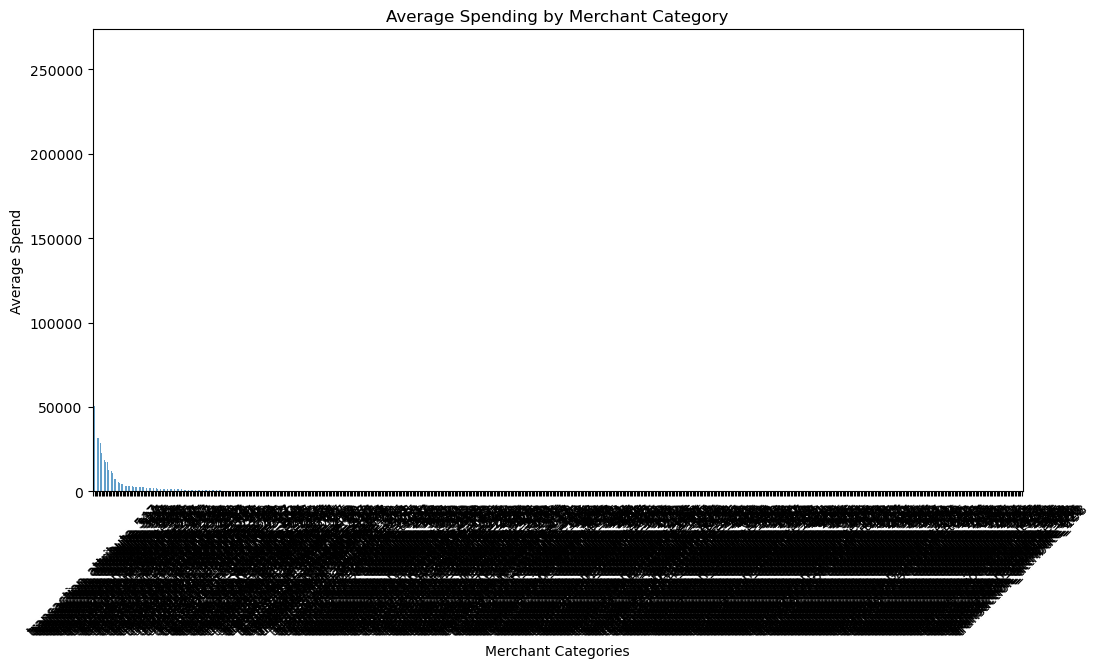


Insight 6: Inquiry Load


C:\Users\allmi\AppData\Local\Temp\ipykernel_20612\2458571251.py:102: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['inquiry_load'] = df[bureau_enquiry_cols].sum(axis=1)


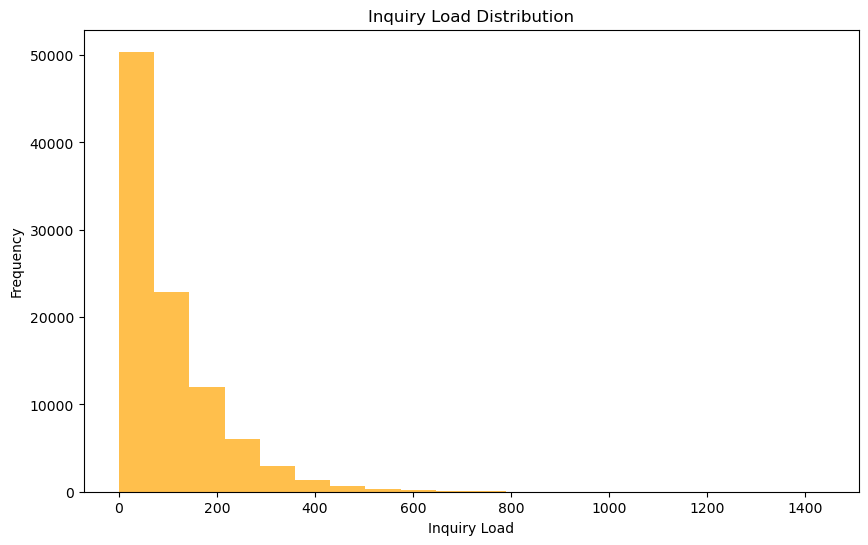


Insight 7: Delinquency Potential


C:\Users\allmi\AppData\Local\Temp\ipykernel_20612\2458571251.py:112: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['delinquency_score'] = df[bureau_cols].sum(axis=1) / (df[bureau_enquiry_cols].sum(axis=1) + 1e-9)


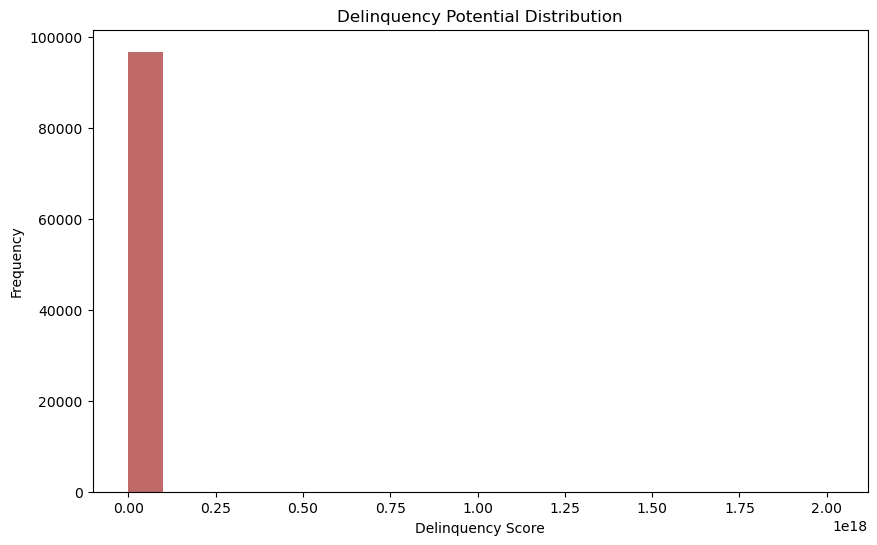


Insight 8: Transaction Concentration


C:\Users\allmi\AppData\Local\Temp\ipykernel_20612\2458571251.py:122: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['transaction_concentration'] = df[transaction_cols].max(axis=1) / df[transaction_cols].sum(axis=1)


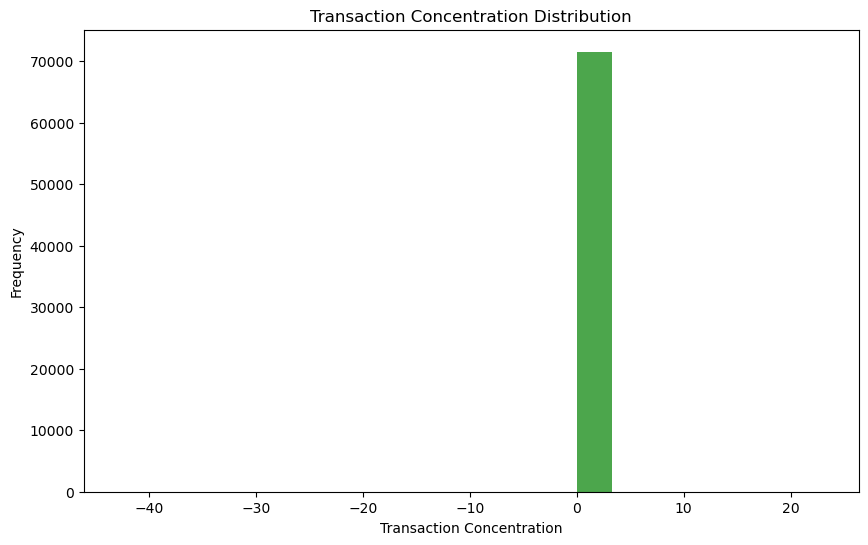


Insight 9: Credit Limit Utilization


C:\Users\allmi\AppData\Local\Temp\ipykernel_20612\2458571251.py:132: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['credit_limit_utilization'] = df[transaction_cols].sum(axis=1) / (df[onus_cols].sum(axis=1) + 1e-9)


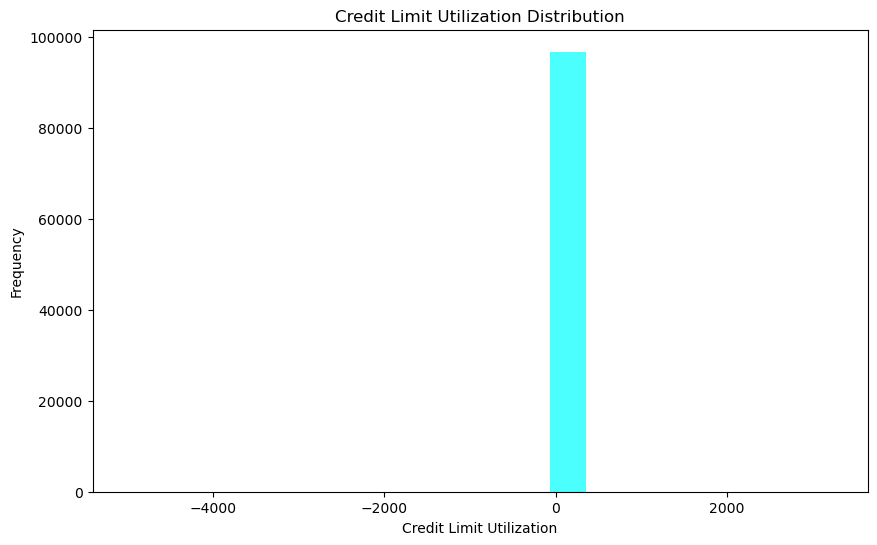


Insight 10: Spend Distribution Skewness


C:\Users\allmi\AppData\Local\Temp\ipykernel_20612\2458571251.py:142: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['spend_skewness'] = df[transaction_cols].skew(axis=1)


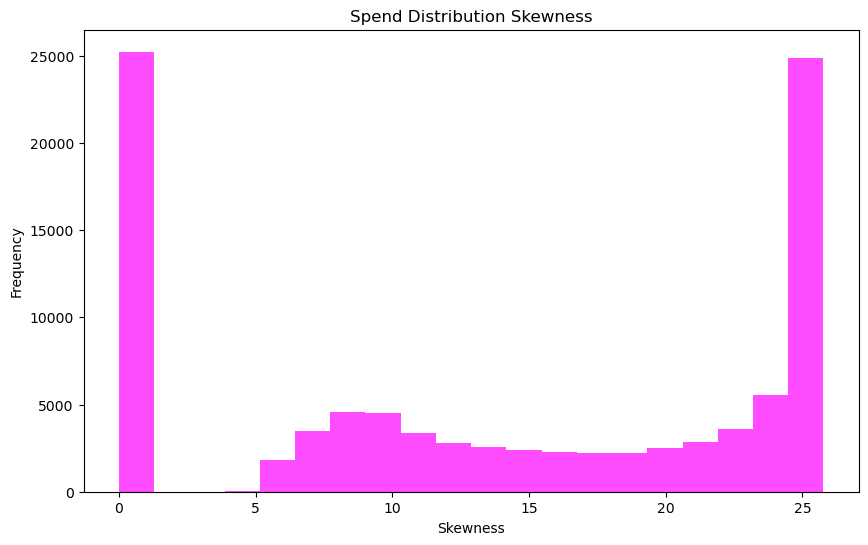


Sampled Account Insights:
       spending_elasticity  financial_stress_score  overleveraged  \
51397             0.000000            6.112664e+06           True   
52601             0.000000            1.152601e+07           True   
89153             3.452332            4.039110e+05          False   
93456             4.953901            8.014827e+07           True   
7565             10.251892            3.115887e+07           True   
67411             3.589802            1.638964e+07           True   
64871             6.084555            3.728058e+06           True   
56213            10.065061            2.338715e+06          False   
88236             2.346264            2.434407e+06           True   
51728             8.460214            2.769762e+06           True   

       inquiry_load  delinquency_score  transaction_concentration  \
51397          63.0       9.702541e+04                        NaN   
52601           9.0       1.280667e+06                        NaN   
89153 

In [13]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('Dev_data_to_be_shared.csv')

# -------------------- Section 1: Preprocessing --------------------

# Categorize columns into relevant groups
onus_cols = [col for col in df.columns if col.startswith('onus_attribute')]
transaction_cols = [col for col in df.columns if col.startswith('transaction_attribute')]
bureau_cols = [col for col in df.columns if col.startswith('bureau') and not col.startswith('bureau_enquiry')]
bureau_enquiry_cols = [col for col in df.columns if col.startswith('bureau_enquiry')]

# Data cleaning: Fill missing values
for col in onus_cols:
    df[col] = df[col].fillna(0)

for col in transaction_cols:
    df[col] = df[col].fillna(0)

for col in bureau_cols:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

for col in bureau_enquiry_cols:
    df[col] = df[col].fillna(0)

# Normalize data for clustering
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[transaction_cols])

# -------------------- Section 2: K-Means Clustering --------------------

# Perform K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(normalized_data)

# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['cluster'], c=df['cluster'], cmap='viridis', alpha=0.7)
plt.title("Customer Clusters Based on Transaction Data")
plt.xlabel("Accounts")
plt.ylabel("Cluster")
plt.colorbar(label='Cluster ID')
plt.show()

# -------------------- Section 3: Insight-Wise Analysis --------------------

# 1. Spending Elasticity
print("\nInsight 1: Spending Elasticity")
df['spending_elasticity'] = df[transaction_cols].sum(axis=1) / (df[onus_cols].sum(axis=1) + 1e-9)
plt.figure(figsize=(10, 6))
plt.hist(df['spending_elasticity'], bins=30, alpha=0.7, color='blue')
plt.title("Distribution of Spending Elasticity")
plt.xlabel("Spending Elasticity")
plt.ylabel("Frequency")
plt.show()

# 2. Financial Stress Prediction
print("\nInsight 2: Financial Stress Prediction")
df['financial_stress_score'] = (
    df[bureau_cols].sum(axis=1) +
    df[bureau_enquiry_cols].sum(axis=1) -
    df[transaction_cols].sum(axis=1) / (df[onus_cols].sum(axis=1) + 1e-9)
)
plt.figure(figsize=(10, 6))
plt.plot(df['financial_stress_score'], color='red', alpha=0.7)
plt.title("Financial Stress Across Accounts")
plt.xlabel("Accounts")
plt.ylabel("Stress Score")
plt.show()

# 3. Overleveraged Customers
print("\nInsight 3: Overleveraged Customers")
df['overleveraged'] = df[bureau_cols].sum(axis=1) > df[transaction_cols].sum(axis=1)
plt.figure(figsize=(6, 6))
df['overleveraged'].value_counts().plot(kind='bar', color=['green', 'red'], alpha=0.7)
plt.title("Overleveraged vs Healthy Accounts")
plt.xlabel("Status")
plt.ylabel("Number of Accounts")
plt.xticks(ticks=[0, 1], labels=['Healthy', 'Overleveraged'])
plt.show()

# 5. High-Spending Merchant Categories
print("\nInsight 5: High-Spending Merchant Categories")
merchant_means = df[transaction_cols].mean()
plt.figure(figsize=(12, 6))
merchant_means.sort_values(ascending=False).plot(kind='bar', alpha=0.7)
plt.title("Average Spending by Merchant Category")
plt.xlabel("Merchant Categories")
plt.ylabel("Average Spend")
plt.xticks(rotation=45)
plt.show()

# 6. Inquiry Load
print("\nInsight 6: Inquiry Load")
df['inquiry_load'] = df[bureau_enquiry_cols].sum(axis=1)
plt.figure(figsize=(10, 6))
plt.hist(df['inquiry_load'], bins=20, alpha=0.7, color='orange')
plt.title("Inquiry Load Distribution")
plt.xlabel("Inquiry Load")
plt.ylabel("Frequency")
plt.show()

# 7. Delinquency Potential
print("\nInsight 7: Delinquency Potential")
df['delinquency_score'] = df[bureau_cols].sum(axis=1) / (df[bureau_enquiry_cols].sum(axis=1) + 1e-9)
plt.figure(figsize=(10, 6))
plt.hist(df['delinquency_score'], bins=20, alpha=0.7, color='brown')
plt.title("Delinquency Potential Distribution")
plt.xlabel("Delinquency Score")
plt.ylabel("Frequency")
plt.show()

# 8. Transaction Concentration
print("\nInsight 8: Transaction Concentration")
df['transaction_concentration'] = df[transaction_cols].max(axis=1) / df[transaction_cols].sum(axis=1)
plt.figure(figsize=(10, 6))
plt.hist(df['transaction_concentration'], bins=20, alpha=0.7, color='green')
plt.title("Transaction Concentration Distribution")
plt.xlabel("Transaction Concentration")
plt.ylabel("Frequency")
plt.show()

# 9. Credit Limit Utilization
print("\nInsight 9: Credit Limit Utilization")
df['credit_limit_utilization'] = df[transaction_cols].sum(axis=1) / (df[onus_cols].sum(axis=1) + 1e-9)
plt.figure(figsize=(10, 6))
plt.hist(df['credit_limit_utilization'], bins=20, alpha=0.7, color='cyan')
plt.title("Credit Limit Utilization Distribution")
plt.xlabel("Credit Limit Utilization")
plt.ylabel("Frequency")
plt.show()

# 10. Spend Distribution Skewness
print("\nInsight 10: Spend Distribution Skewness")
df['spend_skewness'] = df[transaction_cols].skew(axis=1)
plt.figure(figsize=(10, 6))
plt.hist(df['spend_skewness'], bins=20, alpha=0.7, color='magenta')
plt.title("Spend Distribution Skewness")
plt.xlabel("Skewness")
plt.ylabel("Frequency")
plt.show()

# -------------------- Section 4: Final Results --------------------

# Summarize all insights for sampled accounts
sampled_accounts = df.sample(10)
print("\nSampled Account Insights:")
print(sampled_accounts[[
    'spending_elasticity', 'financial_stress_score', 'overleveraged', 'inquiry_load', 'delinquency_score',
    'transaction_concentration', 'credit_limit_utilization', 'spend_skewness'
]])

C:\Users\allmi\AppData\Local\Temp\ipykernel_20612\3053978878.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['credit_overextension_risk'] = (


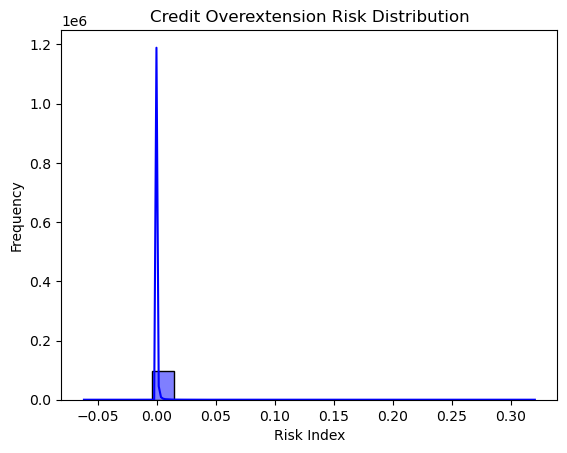

C:\Users\allmi\AppData\Local\Temp\ipykernel_20612\3053978878.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['volatility_index'] = (


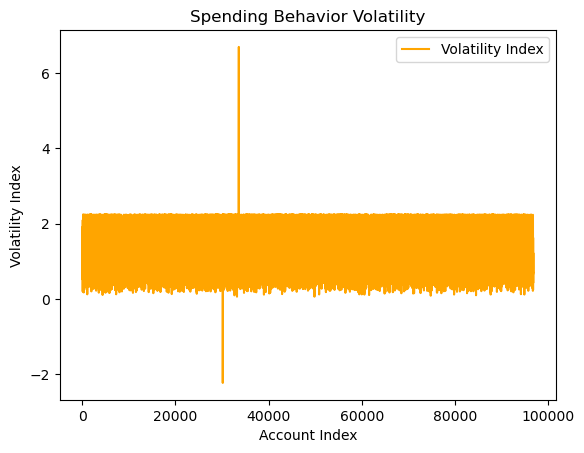

C:\Users\allmi\AppData\Local\Temp\ipykernel_20612\3053978878.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['credit_inquiry_ratio'] = (


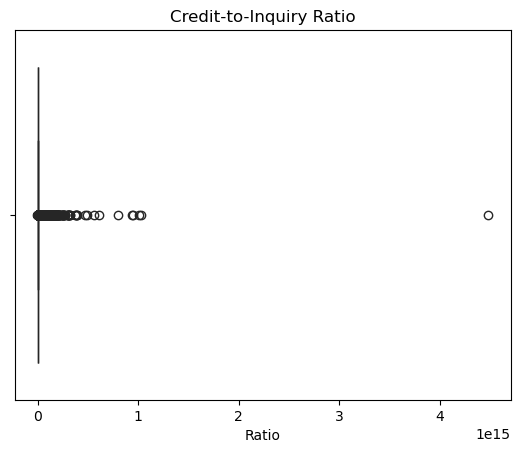

C:\Users\allmi\AppData\Local\Temp\ipykernel_20612\3053978878.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['behavioral_score'] = (


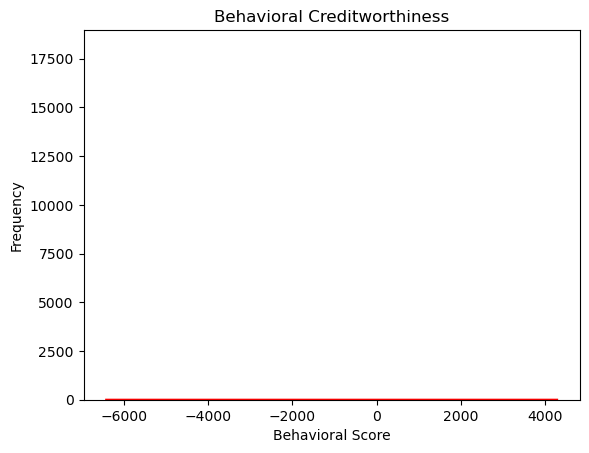

C:\Users\allmi\AppData\Local\Temp\ipykernel_20612\3053978878.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['focus_index'] = df[transaction_cols].mean(axis=1) / total_transactions


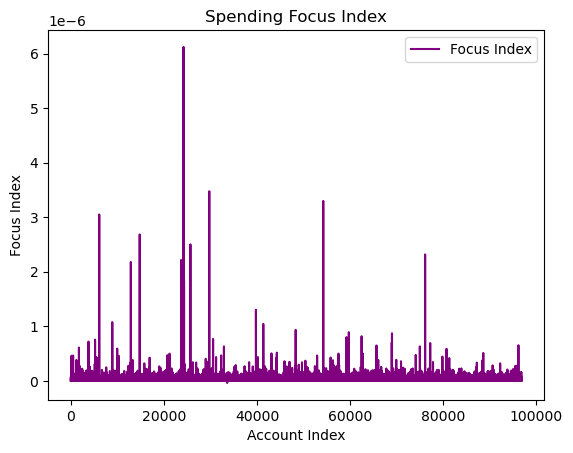

C:\Users\allmi\AppData\Local\Temp\ipykernel_20612\3053978878.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['inquiry_fatigue_score'] = df[bureau_enquiry_cols].mean(axis=1).rolling(window=6).mean()


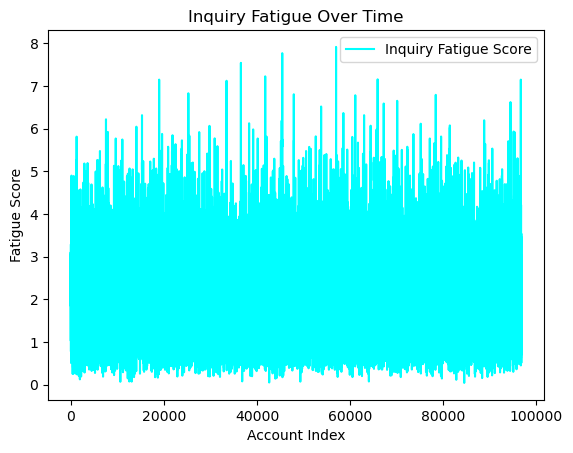

C:\Users\allmi\AppData\Local\Temp\ipykernel_20612\3053978878.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['homogeneity_score'] = df[transaction_cols].mean(axis=1) - transaction_mean


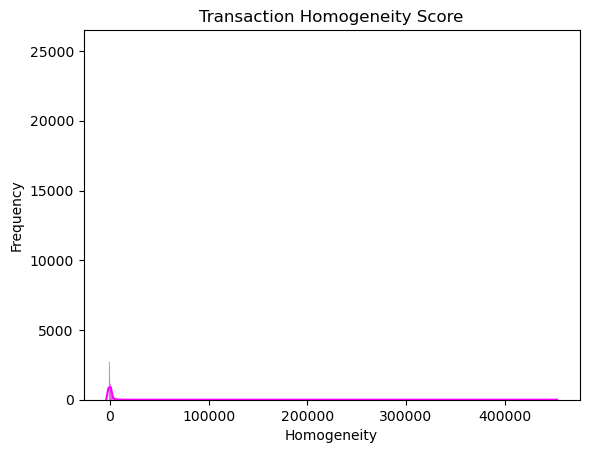

C:\Users\allmi\AppData\Local\Temp\ipykernel_20612\3053978878.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['credit_income_ratio'] = (


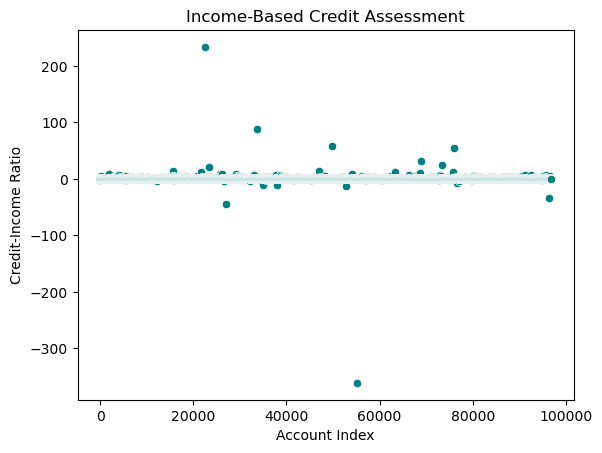

C:\Users\allmi\AppData\Local\Temp\ipykernel_20612\3053978878.py:102: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['risk_zone'] = df[bureau_enquiry_cols].mean(axis=1).apply(classify_risk_zone)
C:\Users\allmi\AppData\Local\Temp\ipykernel_20612\3053978878.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='risk_zone', palette='pastel')


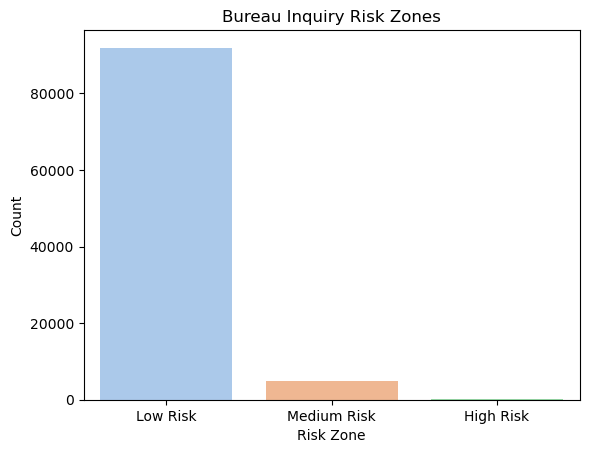

Dataset Summary:

Shape: (96806, 1234)

Sample of calculated metrics:
   credit_overextension_risk  volatility_index  credit_inquiry_ratio  \
0               0.000000e+00               NaN          13198.989759   
1               4.225874e-05               NaN          19922.541190   
2               3.684204e-04               NaN           1639.071503   
3               4.332741e-04               NaN           1118.605601   
4               4.840945e-07          1.528418         155910.606807   

   behavioral_score   focus_index  
0         -0.000458  0.000000e+00  
1         -0.032208  6.351818e-08  
2         -0.088386  5.830665e-09  
3         -0.172599  1.198509e-08  
4         -0.110778  4.558357e-09  


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your already loaded dataframe

# 1. Credit Overextension Risk
df['credit_overextension_risk'] = (
    df[bureau_enquiry_cols].mean(axis=1) / 
    df[bureau_cols].mean(axis=1) * 
    df[transaction_cols].mean(axis=1) / 
    df[onus_cols].mean(axis=1)
)
sns.histplot(df['credit_overextension_risk'], kde=True, bins=20, color='blue')
plt.title("Credit Overextension Risk Distribution")
plt.xlabel("Risk Index")
plt.ylabel("Frequency")
plt.show()

# 2. Spending Behavior Volatility
df['volatility_index'] = (
    df[transaction_cols].mean(axis=1).rolling(window=5).std() / 
    df[transaction_cols].mean(axis=1).rolling(window=5).mean()
)
plt.plot(df.index, df['volatility_index'], label="Volatility Index", color='orange')
plt.title("Spending Behavior Volatility")
plt.xlabel("Account Index")
plt.ylabel("Volatility Index")
plt.legend()
plt.show()

# 3. Credit-to-Inquiry Ratio
df['credit_inquiry_ratio'] = (
    df[bureau_cols].mean(axis=1) / 
    (df[bureau_enquiry_cols].mean(axis=1) + 1e-9)
)
sns.boxplot(data=df, x='credit_inquiry_ratio', color='green')
plt.title("Credit-to-Inquiry Ratio")
plt.xlabel("Ratio")
plt.show()

# 4. Behavioral Creditworthiness
df['behavioral_score'] = (
    (df[transaction_cols].mean(axis=1) - df[onus_cols].mean(axis=1)) / 
    df[bureau_cols].mean(axis=1)
)
sns.histplot(df['behavioral_score'], kde=True, color='red')
plt.title("Behavioral Creditworthiness")
plt.xlabel("Behavioral Score")
plt.ylabel("Frequency")
plt.show()

# 5. Spending Focus Index
total_transactions = df[transaction_cols].sum().sum()
df['focus_index'] = df[transaction_cols].mean(axis=1) / total_transactions
plt.plot(df.index, df['focus_index'], label="Focus Index", color='purple')
plt.title("Spending Focus Index")
plt.xlabel("Account Index")
plt.ylabel("Focus Index")
plt.legend()
plt.show()

# 6. Inquiry Fatigue Trend Analysis
df['inquiry_fatigue_score'] = df[bureau_enquiry_cols].mean(axis=1).rolling(window=6).mean()
plt.plot(df.index, df['inquiry_fatigue_score'], label="Inquiry Fatigue Score", color='cyan')
plt.title("Inquiry Fatigue Over Time")
plt.xlabel("Account Index")
plt.ylabel("Fatigue Score")
plt.legend()
plt.show()

# 8. Transaction Homogeneity Score
transaction_mean = df[transaction_cols].mean(axis=1).mean()
df['homogeneity_score'] = df[transaction_cols].mean(axis=1) - transaction_mean
sns.histplot(df['homogeneity_score'], kde=True, color='magenta')
plt.title("Transaction Homogeneity Score")
plt.xlabel("Homogeneity")
plt.ylabel("Frequency")
plt.show()

# 9. Income-Based Credit Assessment
df['credit_income_ratio'] = (
    df[transaction_cols].mean(axis=1) / 
    (df[onus_cols].mean(axis=1) + 1e-9)
)
sns.scatterplot(x=df.index, y=df['credit_income_ratio'], color='teal')
plt.title("Income-Based Credit Assessment")
plt.xlabel("Account Index")
plt.ylabel("Credit-Income Ratio")
plt.show()

# 10. Bureau Inquiry Risk Zones
def classify_risk_zone(inquiries):
    if inquiries < 6:
        return 'Low Risk'
    elif inquiries < 16:
        return 'Medium Risk'
    else:
        return 'High Risk'

df['risk_zone'] = df[bureau_enquiry_cols].mean(axis=1).apply(classify_risk_zone)
sns.countplot(data=df, x='risk_zone', palette='pastel')
plt.title("Bureau Inquiry Risk Zones")
plt.xlabel("Risk Zone")
plt.ylabel("Count")
plt.show()

# Summary
print("Dataset Summary:")
print("\nShape:", df.shape)
print("\nSample of calculated metrics:")
print(df[['credit_overextension_risk', 'volatility_index', 'credit_inquiry_ratio', 
         'behavioral_score', 'focus_index']].head())